# Colab Hardware Info

In [ ]:
!nvidia-smi

Fri Jun  2 23:02:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

# Download The Dataset

In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3
From (redirected): https://drive.google.com/uc?id=1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3&confirm=t&uuid=2bb5e5ac-e900-4257-8bbf-c25060ab46e5
To: /content/masks_patches_filltered_train.zip
100% 18.9M/18.9M [00:00<00:00, 168MB/s]


In [ ]:
!gdown 1hwr7genSo2FpRLpy_x0EnM376mWvV36r

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r
From (redirected): https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r&confirm=t&uuid=1c4b0abe-9c8f-4683-bd18-37be88bde5aa
To: /content/images_patches_filltered_train.zip
100% 6.57G/6.57G [00:57<00:00, 115MB/s]


In [ ]:
!unzip -qq images_patches_filltered_train.zip -d /
!unzip -qq masks_patches_filltered_train.zip -d /

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing

In [ ]:
import pandas as pd
import numpy as np
import os
import json
import torchvision as tv
import torch
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torchsummary import summary
import math
import ast

#Other Functions

In [ ]:
def show_mask(img,mask,pred,figsize=(12,12)):

    f, axarr = plt.subplots(1,3,figsize=figsize)
    axarr[0].title.set_text('Image')
    axarr[1].title.set_text('Mask')
    axarr[2].title.set_text('predected')
    axarr[0].imshow(img)

    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(pred, cmap='gray')

def eval_show(dataset, ind):
    img, mask = dataset[ind]
    model.eval()
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device))
    
    img = img.permute(1, 2, 0).cpu().numpy()
    # img, mask = img.permute(1, 2, 0), mask.squeeze(0)
    pred = out.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    show_mask(img,mask,pred)

def read_and_polt_history_file(filename):
    with open(filename) as f:
        data = f.read()
    d = ast.literal_eval(data)
    print("Data type before reconstruction : ", type(d))
    df = pd.DataFrame.from_dict(d)
    df.index = df.index.map(str)
    df.index.rename('Epoch',inplace=True)
    df = df.reset_index() 
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'val_loss', color = 'green',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'train_loss', color = 'blue',ax = ax)
    plt.title('Loss Dice')
    plt.show()
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'val_acc', color = 'red',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'train_acc', color = 'yellow',ax = ax)
    plt.title('Accuracy')
    plt.show()
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'val_iou', color = 'red',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'train_iou', color = 'blue',ax = ax)
    plt.title('Intersection Over Union')
    plt.show()

    return df

#Preprocessing

In [ ]:
root = '/content'
img_list = sorted(os.listdir(root + '/images_patches'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)

df

,slide_no,region_no,patch_position_x,patch_position_y,img_fullpath,mask_fullpath,whitepixels,blackpixels,whitepixels_rate,epidermis_percentage
0,01,0,0,0,/content/images_patches/01_0_0_0.png,/content/masks_patches/01_0_0_0.png,79868,182276,0.304672,31.0
1,01,0,0,1,/content/images_patches/01_0_0_1.png,/content/masks_patches/01_0_0_1.png,90675,171469,0.345898,35.0
2,01,0,0,2,/content/images_patches/01_0_0_2.png,/content/masks_patches/01_0_0_2.png,93041,169103,0.354923,36.0
3,01,1,0,0,/content/images_patches/01_1_0_0.png,/content/masks_patches/01_1_0_0.png,107013,155131,0.408222,41.0
4,01,1,0,1,/content/images_patches/01_1_0_1.png,/content/masks_patches/01_1_0_1.png,122773,139371,0.468342,47.0
...,...,...,...,...,...,...,...,...,...,...
11017,50,0,7,0,/content/images_patches/50_0_7_0.png,/content/masks_patches/50_0_7_0.png,88323,173821,0.336926,34.0
11018,50,0,7,1,/content/images_patches/50_0_7_1.png,/content/masks_patches/50_0_7_1.png,89132,173012,0.340012,35.0
11019,50,0,8,0,/content/images_patches/50_0_8_0.png,/content/masks_patches/50_0_8_0.png,165774,96370,0.632378,64.0
11020,50,0,8,1,/content/images_patches/50_0_8_1.png,/content/masks_patches/50_0_8_1.png,11481,250663,0.043797,5.0


In [ ]:
df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']>=50 
# lower_tu = df_filtered['epidermis_percentage']<=90

df_filtered = df_filtered[lower_tu]
df_filtered = df_filtered[upper_th]
df_filtered

<ipython-input-5-f36b43b6deec>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[upper_th]


,slide_no,region_no,patch_position_x,patch_position_y,img_fullpath,mask_fullpath,whitepixels,blackpixels,whitepixels_rate,epidermis_percentage
0,01,0,0,0,/content/images_patches/01_0_0_0.png,/content/masks_patches/01_0_0_0.png,79868,182276,0.304672,31.0
1,01,0,0,1,/content/images_patches/01_0_0_1.png,/content/masks_patches/01_0_0_1.png,90675,171469,0.345898,35.0
2,01,0,0,2,/content/images_patches/01_0_0_2.png,/content/masks_patches/01_0_0_2.png,93041,169103,0.354923,36.0
3,01,1,0,0,/content/images_patches/01_1_0_0.png,/content/masks_patches/01_1_0_0.png,107013,155131,0.408222,41.0
4,01,1,0,1,/content/images_patches/01_1_0_1.png,/content/masks_patches/01_1_0_1.png,122773,139371,0.468342,47.0
...,...,...,...,...,...,...,...,...,...,...
11015,50,0,6,1,/content/images_patches/50_0_6_1.png,/content/masks_patches/50_0_6_1.png,160271,101873,0.611385,62.0
11017,50,0,7,0,/content/images_patches/50_0_7_0.png,/content/masks_patches/50_0_7_0.png,88323,173821,0.336926,34.0
11018,50,0,7,1,/content/images_patches/50_0_7_1.png,/content/masks_patches/50_0_7_1.png,89132,173012,0.340012,35.0
11019,50,0,8,0,/content/images_patches/50_0_8_0.png,/content/masks_patches/50_0_8_0.png,165774,96370,0.632378,64.0


In [ ]:
df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df2

0      16.104155
1       5.652332
2       2.077663
3       1.932499
4       1.551443
         ...    
96      0.326619
97      0.290328
98      0.444565
99      0.562511
100     5.470876
Name: slide_no, Length: 101, dtype: float64

In [ ]:
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)
df_filtered2

0     1.731768
1     1.712526
2     1.885703
3     2.232057
4     2.251299
        ...   
66    0.596498
67    0.711949
68    0.769675
69    0.596498
70    0.711949
Name: slide_no, Length: 71, dtype: float64

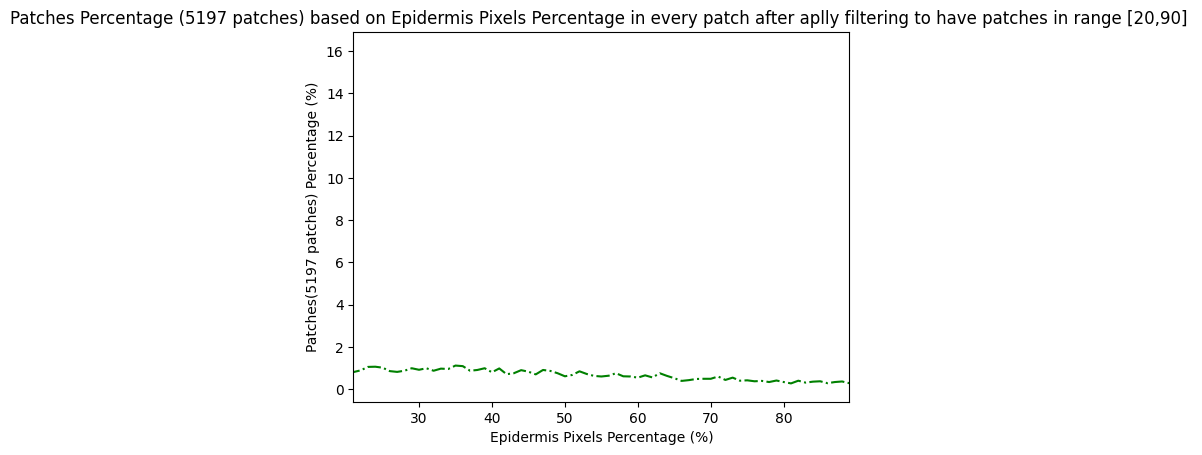

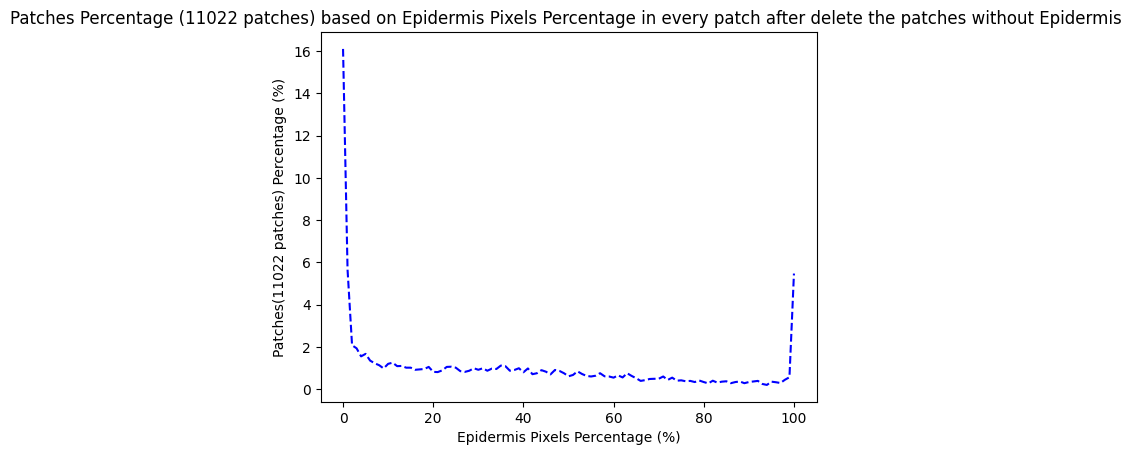

In [ ]:
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title('Patches Percentage ('+str(len(df_filtered))+' patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [20,90] ')
ax.set_xlim(21, 89)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

# Dataset Class

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
class EpidermisDataset(Dataset):
  def __init__(self, df, img_transform=None, mask_transform=None):
    self.df = df
    if img_transform is None:
        self.img_transform = tv.transforms.ToTensor()
    else:
        self.img_transform = img_transform

    if mask_transform is None:
        self.mask_transform = tv.transforms.ToTensor()
    else:
        self.mask_transform = mask_transform

  def __getitem__(self, idx):
    data = self.df.iloc[idx]
    img = Image.open(data['img_fullpath']).convert('RGB')
    mask = Image.open(data['mask_fullpath'])

    img, mask = self.img_transform(img), self.mask_transform(mask)
    
    
    return img, mask

  def __len__(self):
    return len(self.df)

# Model Class

## EncoderBlock Class:

In [ ]:
class EncoderBlock(nn.Module):
    
    def __init__(
        self, in_channels, out_channels, batchnorm=True, activation_fn=nn.ReLU
    ):
        super().__init__()
        
        layers = []
        
        self.batchnorm=batchnorm
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )

        self.activation = activation_fn()
        
        if self.batchnorm:
            self.batchnorm = nn.BatchNorm2d(
                num_features=out_channels
            )
        
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.activation(x)

        if self.batchnorm:
            x = self.batchnorm(x)
        
        return x

## DecoderBlock Class:

In [ ]:
class DecoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, activation_fn=nn.ReLU):
        super().__init__()
        
        self.upconv = nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
        
        self.activation = activation_fn()

        self.batchnorm = nn.BatchNorm2d(
            num_features=out_channels
        )
        
        
    def forward(self, x, skip_in):
        
        x = self.upconv(x)
        
        x = x + skip_in
        x = self.activation(x)
        
        x = self.batchnorm(x)
        
        return x

## LinkNet Class:

In [ ]:
class LinkNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (3, 256, 256) -> (32, 128, 128)
        self.e1 = EncoderBlock(in_channels=3, 
            out_channels=32
        )
        
        # (32, 128, 128) -> (64, 64, 64)
        self.e2 = EncoderBlock(
            in_channels=32, 
            out_channels=64
        )
        
        # (64, 64, 64) -> (128, 32, 32)
        self.e3 = EncoderBlock(
            in_channels=64, 
            out_channels=128
        )
        
        # (128, 32, 32) -> (256, 16, 16)
        self.e4 = EncoderBlock(
            in_channels=128, 
            out_channels=256
        )

        self.e5 = EncoderBlock(
            in_channels=256,
            out_channels=512
        )
        
        # bottleneck (512, 8, 8) -> (512, 4, 4)
        self.b = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
        # (512, 4, 4) -> (512, 8, 8)
        self.d1 = DecoderBlock(
            in_channels=512, 
            out_channels=512
        )
        
        # (512, 8, 8) -> (256, 16, 16)
        self.d2 = DecoderBlock(
            in_channels=512, 
            out_channels=256
        )
        
        # (256, 16, 16) -> (128, 32, 32)
        self.d3 = DecoderBlock(
            in_channels=256, 
            out_channels=128
        )
        
        # (128, 32, 32) -> (64, 64, 64)
        self.d4 = DecoderBlock(
            in_channels=128, 
            out_channels=64
        )
        
        # (64, 64, 64) -> (32, 128, 128)
             
        self.d5 = DecoderBlock(
            in_channels=64, 
            out_channels=32
        )
        
        # output (32, 128, 128) -> (1, 256, 256)
        self.o = nn.ConvTranspose2d(
            in_channels=32, 
            out_channels=1, 
            padding=(1, 1), 
            padding_mode='zeros', 
            kernel_size=(4, 4), 
            stride=(2, 2)
        )
        
    def forward(self, x):
        
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        
        b = self.b(e5)
        b = F.relu(b)
        
        d1 = self.d1(b, e5)
        d2 = self.d2(d1, e4)
        d3 = self.d3(d2, e3)
        d4 = self.d4(d3, e2)
        d5 = self.d5(d4, e1)
        
        output = self.o(d5)
        output = torch.sigmoid(output)

        return output

# Dice Loss

In [ ]:
class DiceLoss(nn.Module):
    
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

# Train & Evaluation Functions

In [ ]:
def train(
    model, optimizer, criterion, train_loader, val_loader, epochs, save_path: str, acc_threshold=0.7
):
    history = {
        "val_loss": [], "train_loss": [], "val_acc": [], "train_acc": [],
        "val_iou": [], "train_iou": []
    }
    min_loss = math.inf
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_iou = 0.0
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            y_hat = model(x)
            loss = criterion(y_hat, y)
            train_loss += loss.item()

            y_hat_acc = y_hat.clone()

            y_hat_acc[y_hat_acc >= acc_threshold] = 1
            y_hat_acc[y_hat_acc < acc_threshold] = 0
            y_hat_acc = y_hat_acc.byte()

            train_acc += (y_hat_acc == y).sum() / y[0].nelement()

            tp = (y_hat_acc * y).squeeze(1).sum(1).sum(1)

            tmp = (y_hat_acc + y).squeeze(1)
            tp_fp_fn = (tmp != 0).sum(1).sum(1)
            # print(tp, tp_fp_fn, tp.shape, tp_fp_fn.shape)
            train_iou +=  (tp / tp_fp_fn).sum()

            loss.backward()
            optimizer.step()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)
        train_iou = train_iou / len(train_loader.dataset)
        
        val_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0

        model.eval()
        with torch.no_grad():
            for i, (x, y) in enumerate(val_loader):
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                y_hat_acc = y_hat.clone()
                y_hat_acc[y_hat_acc >= acc_threshold] = 1
                y_hat_acc[y_hat_acc < acc_threshold] = 0
                val_loss += loss.item()
                val_acc += (y_hat_acc == y).sum() / y[0].nelement()

                tp = (y_hat_acc * y).squeeze(1).sum(1).sum(1)
                tmp = (y_hat_acc + y).squeeze(1)
                tp_fp_fn = (tmp != 0).sum(1).sum(1)
                val_iou +=  (tp / tp_fp_fn).sum()
            
            val_loss = val_loss / len(val_loader)
            val_acc = val_acc / len(val_loader.dataset)
            val_iou = val_iou / len(val_loader.dataset)
        
        history['val_loss'].append(val_loss)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_acc.item())
        history['val_iou'].append(val_iou.item())
        history['train_iou'].append(train_iou.item())

        print(f"Train Loss:\t{train_loss:.5f} | Val. Loss:\t{val_loss:.5f}")
        print(f"Train Acc: \t{train_acc:.5f} | Val. acc: \t{val_acc:.5f}")
        print(f"Train iou: \t{train_iou:.5f} | Val. iou:\t{val_iou: .5f}")
        if min_loss > val_loss:
            min_loss = val_loss
            torch.save({
                "history": history,
                 "model_state": model.state_dict()
            }, save_path)

        print("=" * 25 + "End of Epoch " + str(epoch+1) + "=" * 25)


    return history


In [ ]:
def evaluate(model, test_loader, criterion, acc_threshold: float = 0.7):
    model.eval()
    acc = 0
    loss = 0
    iou = 0
    with torch.no_grad():
        for i,(x, y) in enumerate(test_loader):
            if i%10 == 0:
                print(' ')
            print(f'batch {i+1} =>',end=" ")
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            y_hat_acc = y_hat.clone()
            y_hat_acc[y_hat_acc >= acc_threshold] = 1
            y_hat_acc[y_hat_acc < acc_threshold] = 0

            acc += (y_hat_acc == y).sum() / y[0].nelement()

            loss += criterion(y_hat, y).item()

            tp = (y_hat_acc * y).squeeze(1).sum(1).sum(1)
            
            tmp = (y_hat_acc + y)
            tp_fp_fn = (tmp != 0).squeeze(1).sum(1).sum(1)

            iou +=  (tp / tp_fp_fn).sum()

    model.train()
    acc = acc / len(test_loader.dataset)
    loss = loss / len(test_loader)
    iou = iou / len(test_loader.dataset)
    
    return {"acc": acc.item(), "loss": loss, "iou": iou.item()}



#***Training***  ⚠ Run for Training a Model ONLY

In [ ]:
img_transform = tv.transforms.Compose([
    tv.transforms.Resize((512, 512)),
    tv.transforms.ToTensor(),
])
train_df = df_filtered
mask_transform = img_transform
train_dataset = EpidermisDataset(train_df, img_transform=img_transform, mask_transform=mask_transform)

In [ ]:
train_ds, val_ds= random_split(train_dataset, [0.8, 0.2])

In [ ]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

In [ ]:
criterion = DiceLoss()
model = LinkNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
history = train(model, optimizer, criterion, train_loader, val_loader, 60, "best.pt")

Train Loss:	0.24775 | Val. Loss:	0.22398
Train Acc: 	0.78144 | Val. acc: 	0.75190
Train iou: 	0.64152 | Val. iou:	 0.66182
=========================End of Epoch 1=========================
Train Loss:	0.15896 | Val. Loss:	0.14924
Train Acc: 	0.85475 | Val. acc: 	0.86452
Train iou: 	0.75326 | Val. iou:	 0.77117
=========================End of Epoch 2=========================
Train Loss:	0.14538 | Val. Loss:	0.19119
Train Acc: 	0.86650 | Val. acc: 	0.84781
Train iou: 	0.76915 | Val. iou:	 0.72475
=========================End of Epoch 3=========================
Train Loss:	0.13832 | Val. Loss:	0.12976
Train Acc: 	0.87290 | Val. acc: 	0.88493
Train iou: 	0.77860 | Val. iou:	 0.79273
=========================End of Epoch 4=========================
Train Loss:	0.13092 | Val. Loss:	0.15437
Train Acc: 	0.87975 | Val. acc: 	0.87293
Train iou: 	0.78862 | Val. iou:	 0.77135
=========================End of Epoch 5=========================
Train Loss:	0.13080 | Val. Loss:	0.13993
Train Acc: 	0.87960

In [ ]:
with open('history.txt', 'w') as convert_file:
     convert_file.write(json.dumps(history))
history

{'val_loss': [0.22397549947102866,
  0.14923581812116835,
  0.19118854734632704,
  0.12975856992933485,
  0.15436620844735038,
  0.13993324173821342,
  0.1265750659836663,
  0.12989178631040785,
  0.3091474639044868,
  0.14731605847676596,
  0.1293166677157084,
  0.11725429693857829,
  0.13475674390792847,
  0.11346920331319173,
  0.11532019906573826,
  0.1436667111184862,
  0.11802518367767334,
  0.15435181061426798,
  0.10812603765063816,
  0.10908279816309611,
  0.1325529482629564,
  0.13092799319161308,
  0.09984672731823391,
  0.10978767606947157,
  0.10378162066141765,
  0.10847214857737224,
  0.1280914478831821,
  0.1040152178870307,
  0.13228129678302342,
  0.10191178984112209,
  0.17878709899054634,
  0.10067181454764472,
  0.09865342908435398,
  0.09957803620232476,
  0.14117981990178427,
  0.10389720731311375,
  0.10670118199454413,
  0.10406041145324707,
  0.10199428266949123,
  0.10205062892701891,
  0.10616595877541436,
  0.10751960674921672,
  0.10182328356636895,
  0.10

Data type before reconstruction :  <class 'dict'>


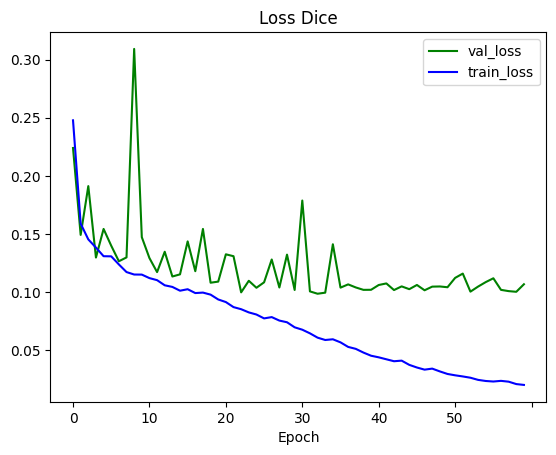

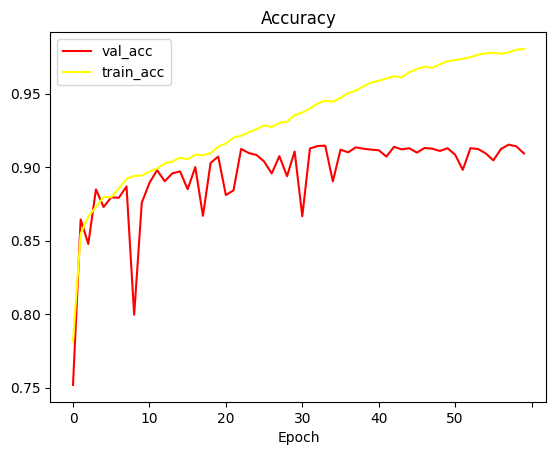

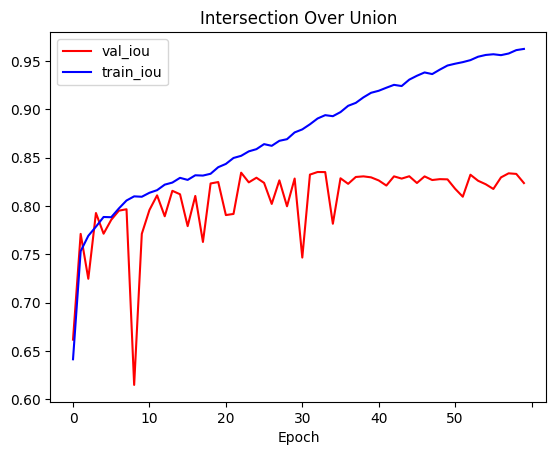

In [ ]:
history_df = read_and_polt_history_file('history.txt')